In [1]:
#%run utility_getinputhits.py

In [1]:
from pylab import *
import pandas as pd
from timeit import default_timer as timer

In [2]:
Points = np.fromfile("../data/MNIST/MNIST_train_data_AEcnn.dat").reshape(-1,10)
Points = Points[:1000]
Points = Points/Points.max()
nPoints,kPoints = Points.shape
wPoints = np.ones(nPoints)

In [46]:
def dis(p1,p2):
    return np.sqrt( np.sum((p1-p2)**2, axis=-1) )

MAXDISTANCE        = 0.1
KERNAL_R           = 0.05
KERNAL_R_NORM      = 0.05
KERNAL_R_POWER     = 2.0
DECISION_RHO_KAPPA = 6.0
DECISION_NHD       = 0.04
CONTINUITY_NHD     = 0.1


# 1. Find rho and NearestHigher

In [47]:
start = timer()

# find rho and rhorank
rho = []
for i in range(nPoints):
    dr = dis(Points, Points[i])
    local = (dr<KERNAL_R)
    irho = np.sum( wPoints[local] * np.exp( -(dr[local]/KERNAL_R_NORM)**KERNAL_R_POWER  ))
    rho.append(irho)
rho = np.array(rho)
argsortrho = rho.argsort()[::-1]
rhorank = np.empty(len(rho), int)
rhorank[argsortrho] = np.arange(len(rho))

# find NearstHiger and distance to NearestHigher
nh,nhd = [],[]
for i in range(nPoints):
    irho  = rho[i]
    irank = rhorank[i]
    
    higher = rho>irho
    # if no points is higher
    if not (True in higher): 
        nh. append(i)
        nhd.append(MAXDISTANCE)
    else:
        drr  = dis(Points[higher], Points[i])
        temp = np.arange(len(rho))[higher]
        nh. append(temp[np.argmin(drr)])
        nhd.append(np.min(drr))

            
nh = np.array(nh)
nhd= np.array(nhd)

end = timer()
print("number of rechits: {}".format(nPoints))

print("time: {:3.6} ms".format(1000*(end - start)))

number of rechits: 1000
time: 145.612 ms


# 2. Asign Clusters

In [48]:
cluster = -np.ones(nPoints,int)
DECISION_RHO = rho.max()/DECISION_RHO_KAPPA

# 2.2 find seeds
selectseed = (rho>DECISION_RHO) & (nhd>DECISION_NHD)
seedrho = rho[selectseed]
temp = seedrho.argsort()[::-1]
seedid = np.empty(len(seedrho), int)
seedid[temp] = np.arange(len(seedrho))
cluster[selectseed] = seedid

# 2.3 asign clusters to seeds
for ith in range(nPoints):
    i = argsortrho[ith]
    if  (cluster[i]<0) & (nhd[i]<CONTINUITY_NHD):
        cluster[i] = cluster[nh[i]]

In [49]:
result = pd.DataFrame()
result['rho'] = pd.Series(rho)
result['rhorank'] = pd.Series(rhorank)
result['nh'] = pd.Series(nh)
result['nhd'] = pd.Series(nhd)

result['isseed'] = pd.Series(selectseed)
result['cluster'] = pd.Series(cluster)


# Make Plots

In [50]:
%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

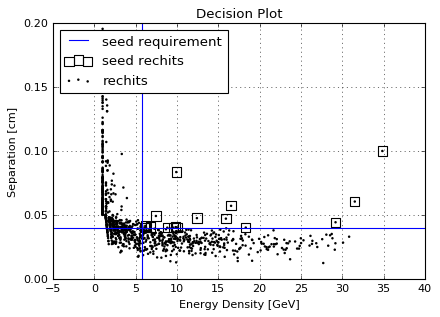

In [51]:
plt.scatter(result.rho[result.isseed],result.nhd[result.isseed],marker='s',
            s=70,edgecolor="k",color="None",label="seed rechits")
plt.scatter(result.rho, result.nhd, marker='.',edgecolor="None",color="k",label="rechits")
plt.axvline(DECISION_RHO,color="b",label="seed requirement")
plt.axhline(DECISION_NHD,color="b")

plt.xlabel("Energy Density [GeV]")
plt.ylabel("Separation [cm]")
plt.legend(loc="upper left",fontsize=12)
plt.xlim(-5)
plt.ylim(0,0.2)
plt.grid(True)
plt.title("Decision Plot",fontsize=12)


IndexError: index 1 is out of bounds for axis 0 with size 1

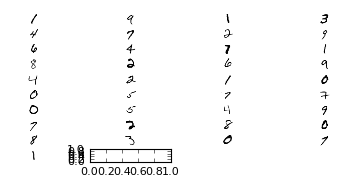

In [53]:
Images = np.fromfile("../data/MNIST/MNIST_train_data.dat").reshape(-1,785)
Images = Images[:,0:-1]
Images = Images[:1000]

seeds = np.unique(result.cluster)
seeds = seeds[seeds>=0]

nrow = seeds.size
ncol = 4

i = 0
for icl in seeds:
    cl = Images[result.cluster==icl]
    for j in range(ncol):
        plt.subplot(nrow, ncol, i*ncol + j+1)
        img = cl[j].reshape(28,28).T
        plt.imshow(img,cmap="Greys")
        plt.axis('off')
    i = i+1